## CHAPTER 8: 어텐션

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

#### 8.1.1 seq2seq의 문제점

+ Encoder의 출력이 고정 길이의 벡터

#### 8.1.2 Encoder 개선

Encoder의 출력의 길이는 입력 문장의 길이에 따라 바꿔주는게 좋습니다.

구체적으로, 시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것입니다.

<img src=attachment:image.png width=400px></img>
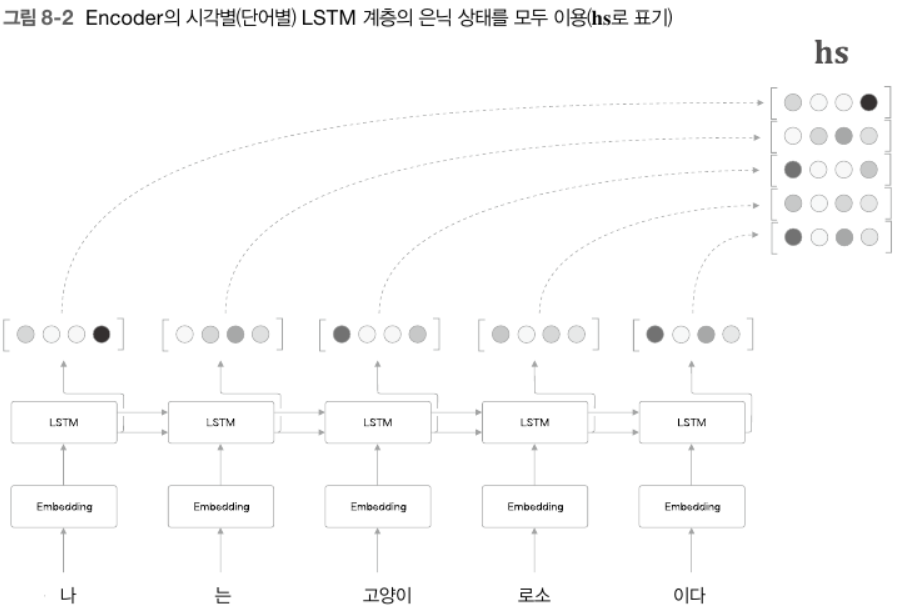

#### 8.1.3 Decoder 개선 ①

'도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라냅니다.

<img src=attachment:image.png width=500px></img><br>

각 단어의 중요도를 나타내는 가중치 a와 각 단어의 벡터 hs로부터 가중합<sup>weighted sum</sup>을 구하여, 맥락 벡터 c를 얻습니다.

<img src=attachment:image-2.png width=500px></img>
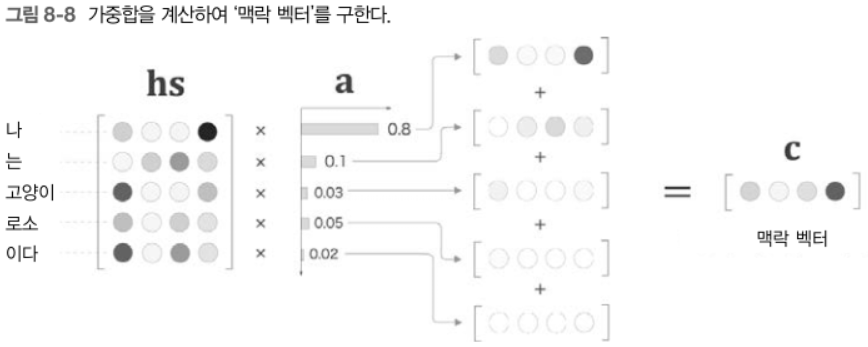
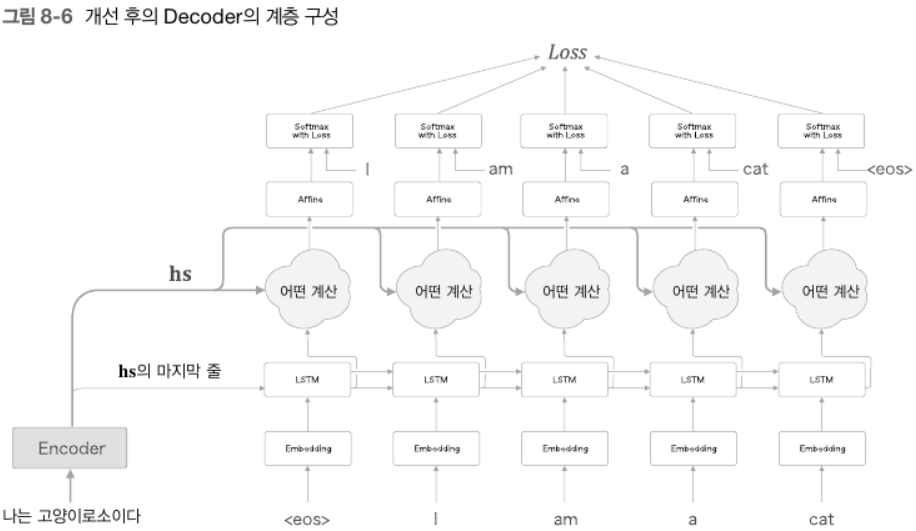

가중합 계산을 계산 그래프로 그려보면 다음과 같습니다.

<img src=attachment:image.png width=200px></img>
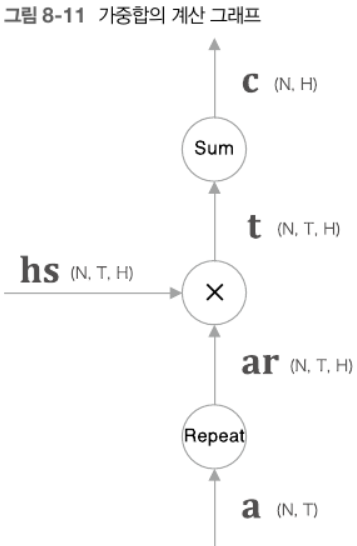

In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N,T,1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
        
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N,1,H).repeat(T, axis=1) # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeat의 역전파
        
        return dhs, da

#### 8.1.4 Decoder 개선 ②

각 단어의 중요도를 나타내는 가중치 a를 어떻게 구해야 할까요?

Decoder의 LSTM 계층의 은닉 상태 벡터 h가 Encoder의 hs의 각 단어 벡터와 얼마나 '비슷한가'를 수치화합니다.

<img src=attachment:image-2.png width=350px></img>

이후 위에서 획득한 s를 정규화하기 위해 소프트맥스 함수를 적용하면 a를 얻을 수 있습니다.
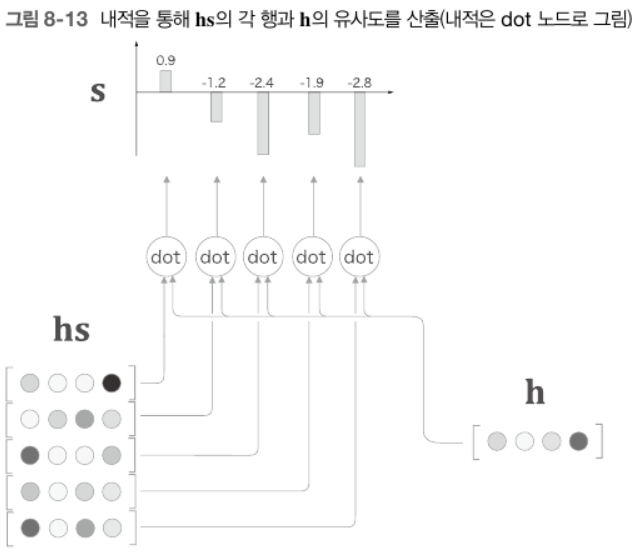

#### 8.1.5 Decoder 개선 ③